0
215
start
220160 [ 0.          0.          0.         ... -0.00842311 -0.00851466
 -0.00845363]


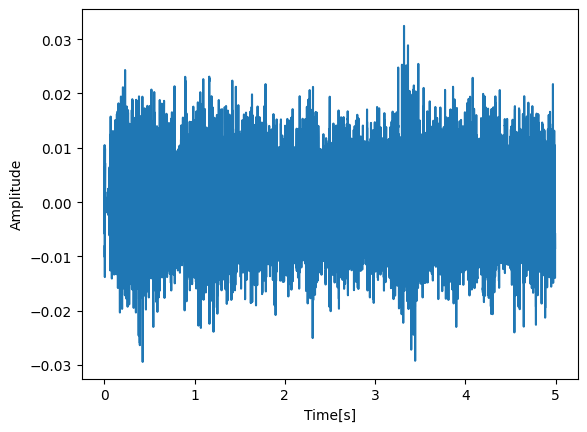

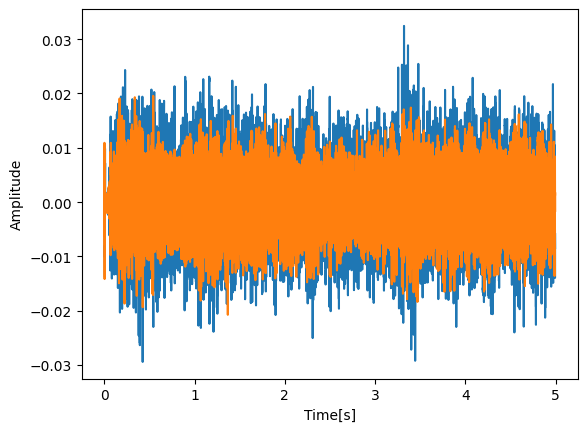

In [8]:
import pyaudio
import numpy as np
from matplotlib import pyplot as plt
import soundfile as sf
import librosa

def get_mic_index(pa):
    """マイクチャンネルを取得する関数"""

    #マイクチャンネル一覧をリストに追加する
    mic_list = []
    for i in range(pa.get_device_count()):
        device_info = pa.get_device_info_by_index(i)
        num_of_input_ch = device_info["maxInputChannels"]

        if num_of_input_ch > 0:
            mic_list.append(device_info["index"])

            return mic_list[0]

def record(pa,index,duration):
    """PCのマイクで録音する関数"""

    #録音条件
    sampling_rate = 44100
    frame_size = 1024

    #ストリームを開く
    stream = pa.open(
        format = pyaudio.paInt16,
        channels = 1,
        rate = sampling_rate,
        input = True,input_device_index = index,
        frames_per_buffer = frame_size
    )

    #ループ数の設定
    dt = 1/sampling_rate
    n = int(((duration/dt)/frame_size))
    print(n)

    #録音する
    waveform = []
    print("start")
    for i in range(n):
        frame = stream.read(frame_size)
        waveform.append(frame)

    #ストリームの終了
    stream.stop_stream()
    stream.close()

    #データをまとめる
    waveform = b"".join(waveform)

    #バイトデータを数値データに変換
    byte_to_num = np.frombuffer(waveform,dtype = "int16")

    #最大値を計算
    max_value = float((2**16/2)-1)

    #波形を正規化
    normalized_waveform = byte_to_num/max_value
    
    return normalized_waveform,sampling_rate

def graph_plot(x,y):
    """波形をグラフにする関数"""

    #グラフの設定
    fig, ax = plt.subplots()
    ax.set_xlabel('Time[s]')
    ax.set_ylabel('Amplitude')

    #データのプロット
    for x_axis,y_axis, in zip(x,y):
        ax.plot(x_axis,y_axis)
    plt.show()
    plt.close()

    return
    

# PyAudioを準備する
pa = pyaudio.PyAudio()

#マイクチャンネルを自動取得
index = get_mic_index(pa)
print(index)

#計測条件を設定して録音関数を実行
duration = 5
waveform,sampling_rate = record(pa,index,duration)
print(len(waveform),waveform)

#PyAudioを終了
pa.terminate()

#グラフをプロットする
dt = 1/sampling_rate
t = np.arange(0,len(waveform)*dt,dt)
graph_plot([t],[waveform])

#wavファイルに保存する
filename = 'recorded.wav'
sf.write(filename,waveform,sampling_rate)

#ボイスチェンジする
n_steps = 8
waveform_shifted = librosa.effects.pitch_shift(waveform,sr=sampling_rate,n_steps=n_steps)

#ビッチシフトされた音声を保存する
sf.write('pitch_shifted.wav',waveform_shifted,sampling_rate)

#音声をグラフで比較する
graph_plot([t,t],[waveform,waveform_shifted])